In [280]:
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from collections import Counter

In [3]:
dep_all_31_01 = pd.read_csv('darunavir_outputs/results_31_01_dep/all_runs_data.csv', names=['episode', 'steps_left', 'similarity','negative_docking_score', 'penalty', 'sucos', 'interactions_penalty', 'num_interactions',
                                                                           'normalised_interactions_penalty', 'sascore', 'ligand_efficiency', 'penalised_negative_docking_score',
                                                                           'dockiing_env_penalty', 'reward', 'discounted_reward', 'smiles', 'qed', 'penalised_logp', 'file_name'], )

total number of training examples

In [284]:
len(dep_all_31_01)

3000

In [295]:
fps_2048_10 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=10, useChirality=True) for smi in dep_all_31_01['smiles']]

In [296]:
fps_2048_3 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=3, useChirality=True) for smi in dep_all_31_01['smiles']]

In [297]:
fps_8192_10 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=10, nBits=8192, useChirality=True) for smi in dep_all_31_01['smiles']]

In [23]:
fps_2048_10 = [fp.ToList() for fp in fps_2048_10]

In [128]:
fps_2048_3 = [fp.ToList() for fp in fps_2048_3]

In [25]:
fps_8192_10 = [fp.ToList() for fp in fps_8192_10]

## let us just have a brief look at how the fingerprint parameters affect which bits are turned on

In [298]:
on_bits_2048_10 = [fp.GetOnBits() for fp in fps_2048_10]
on_bits_2048_3 = [fp.GetOnBits() for fp in fps_2048_3]
on_bits_8192_10 = [fp.GetOnBits() for fp in fps_8192_10]

In [299]:
all_bits_2048_10 = np.concatenate(on_bits_2048_10)
all_bits_2048_3 = np.concatenate(on_bits_2048_3)
all_bits_8192_10 = np.concatenate(on_bits_8192_10)

In [300]:
c_2048_10 = Counter(all_bits_2048_10)
c_2048_3 = Counter(all_bits_2048_3)
c_8192_10 = Counter(all_bits_8192_10)

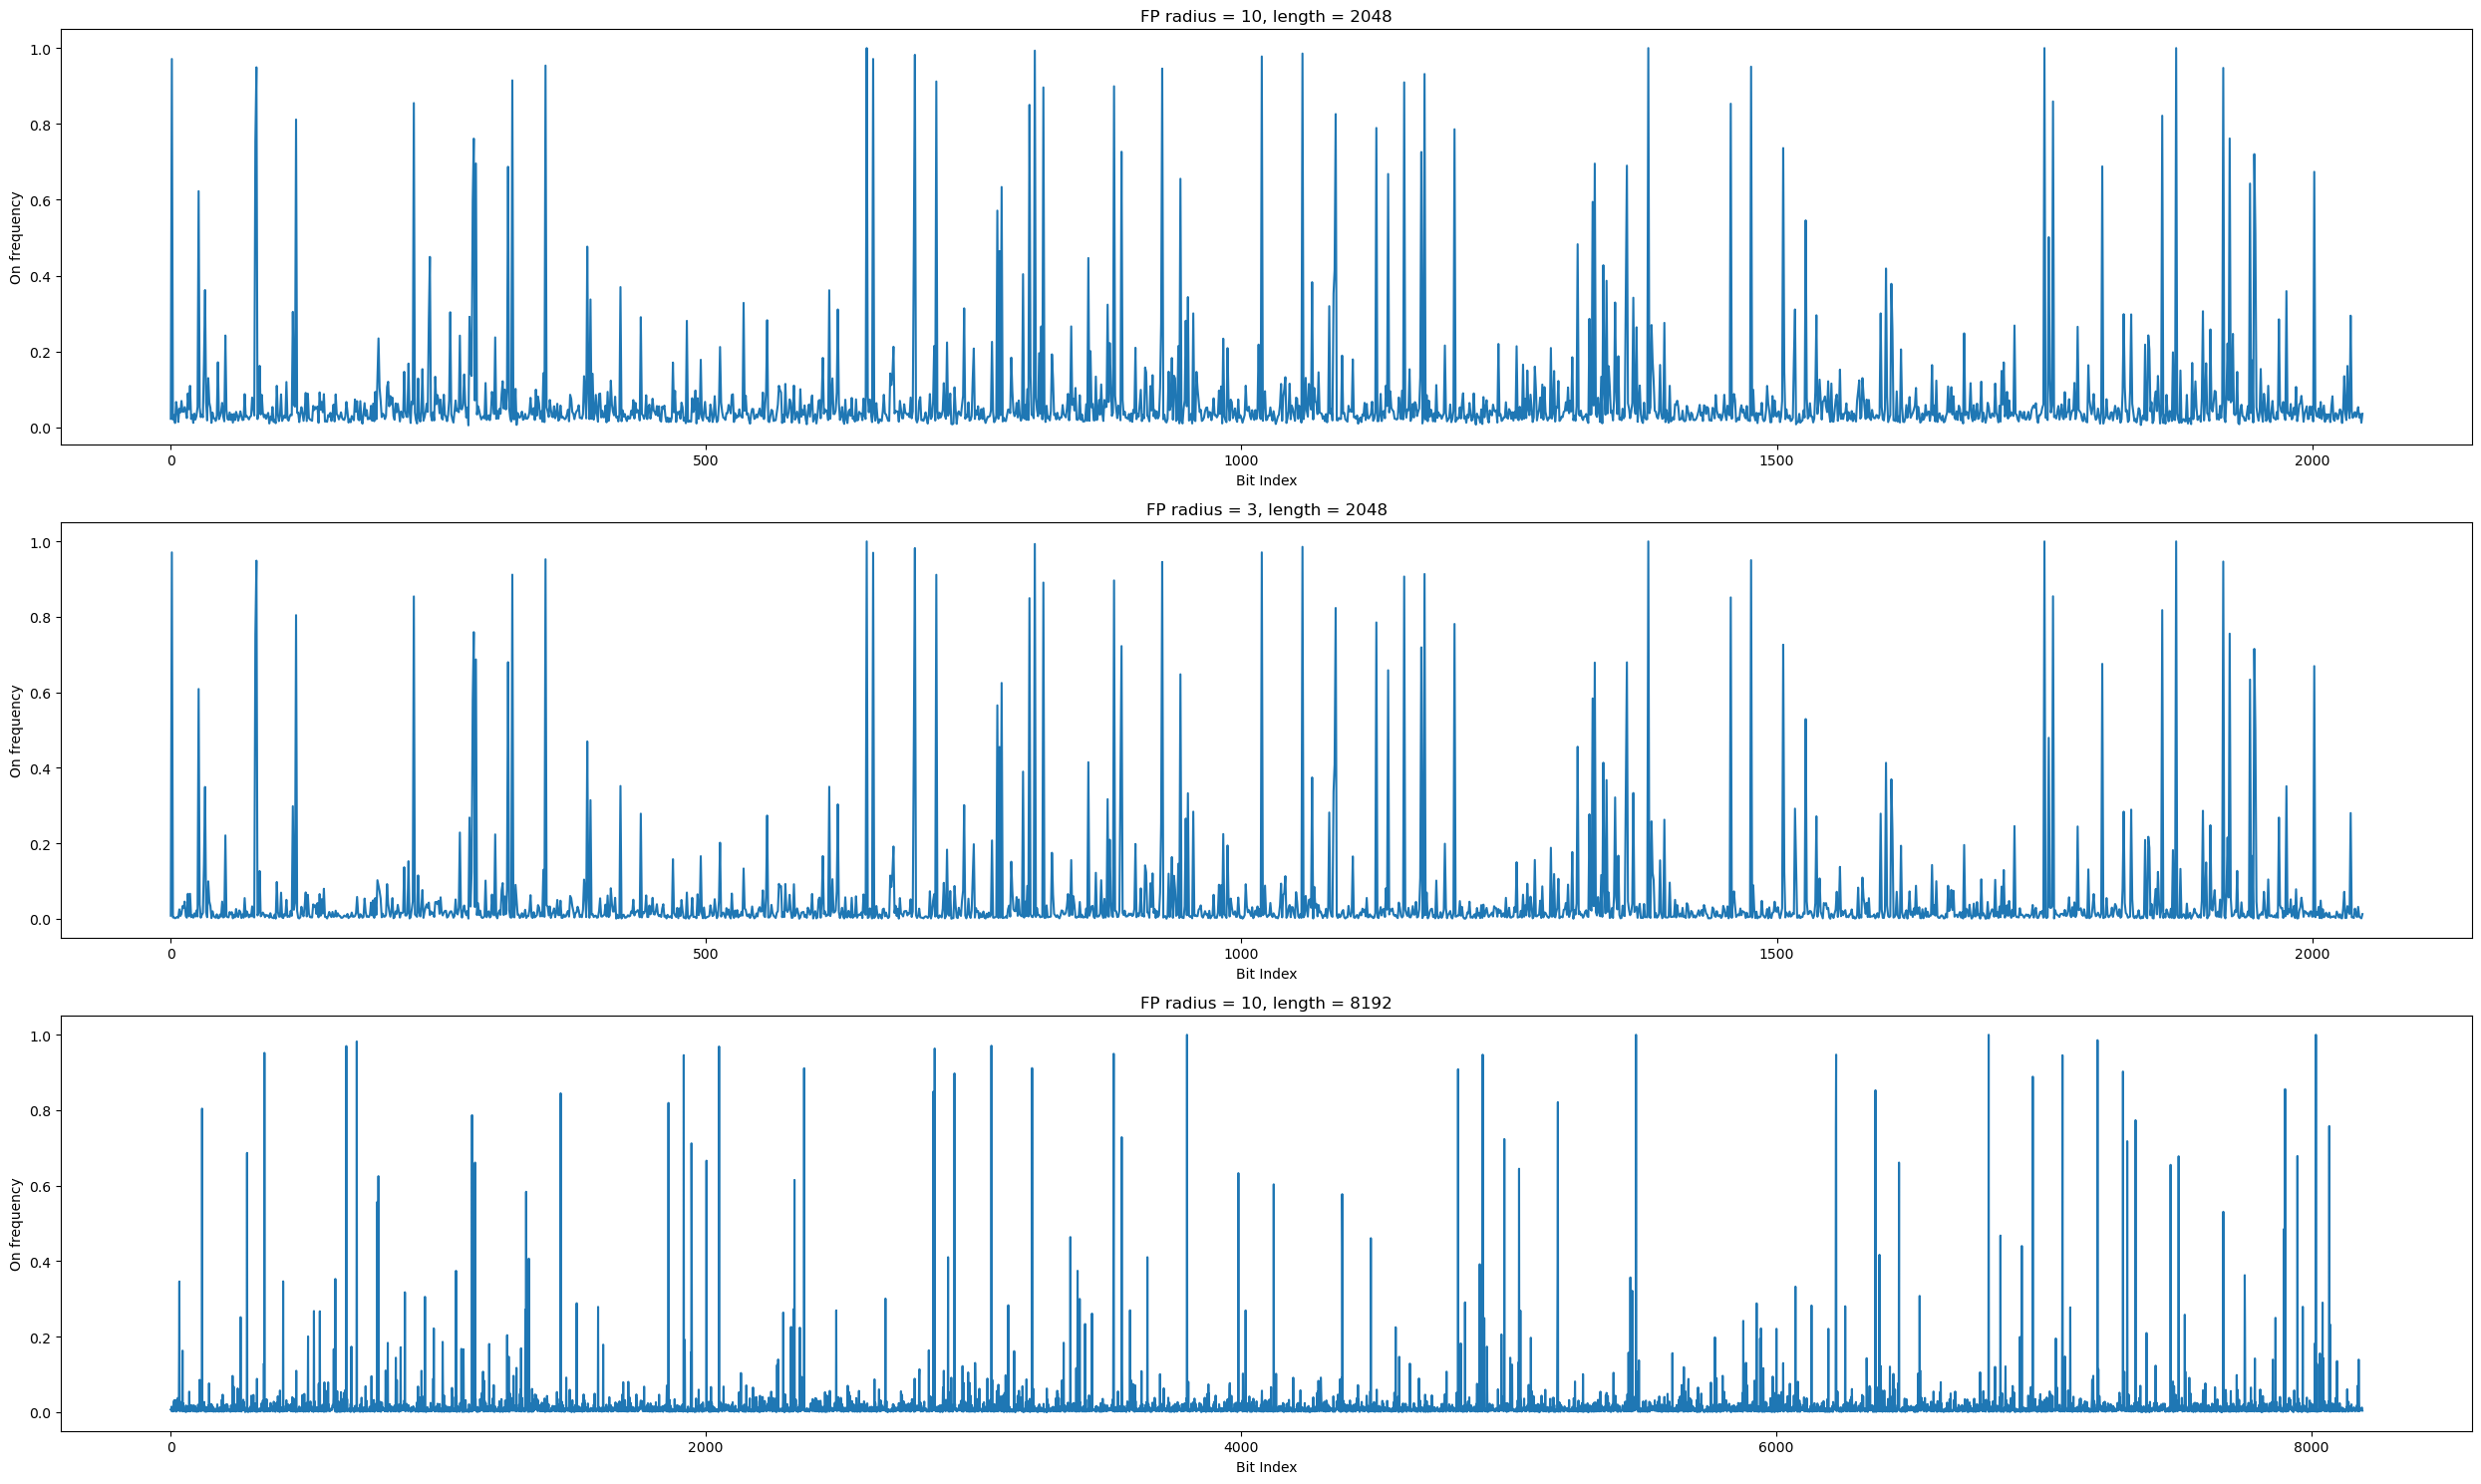

In [304]:
plt.figure(figsize=(25,15))
ax1 = plt.subplot(3,1,1)
sn.lineplot(x=c_2048_10.keys(), y=np.array(list(c_2048_10.values()))/3000)
plt.xlabel('Bit Index')
plt.ylabel('On frequency')
plt.title('FP radius = 10, length = 2048')

ax1 = plt.subplot(3,1,2)
sn.lineplot(x=c_2048_3.keys(), y=np.array(list(c_2048_3.values()))/3000)
plt.xlabel('Bit Index')
plt.ylabel('On frequency')
plt.title('FP radius = 3, length = 2048')

ax1 = plt.subplot(3,1,3)
sn.lineplot(x=c_8192_10.keys(), y=np.array(list(c_8192_10.values()))/3000)
plt.xlabel('Bit Index')
plt.ylabel('On frequency')
plt.title('FP radius = 10, length = 8192')
plt.tight_layout()

In [306]:
def count_more_than_and_less_than_500(counter_dict):
    less = 0
    more = 0
    for k,v in counter_dict.items():
        if v < 500:
            less += 1
        else:
            more += 1
    return more, less

In [307]:
num_of_on_more_than_500_2048_10, num_of_on_less_than_500_2048_10 = count_more_than_and_less_than_500 (c_2048_10)
num_of_on_more_than_500_2048_3, num_of_on_less_than_500_2048_3 = count_more_than_and_less_than_500(c_2048_3)
num_of_on_more_than_500_8192_10, num_of_on_less_than_500_8192_10 = count_more_than_and_less_than_500(c_8192_10)

Text(0.5, 1.0, 'FP radius = 10, length = 2048')

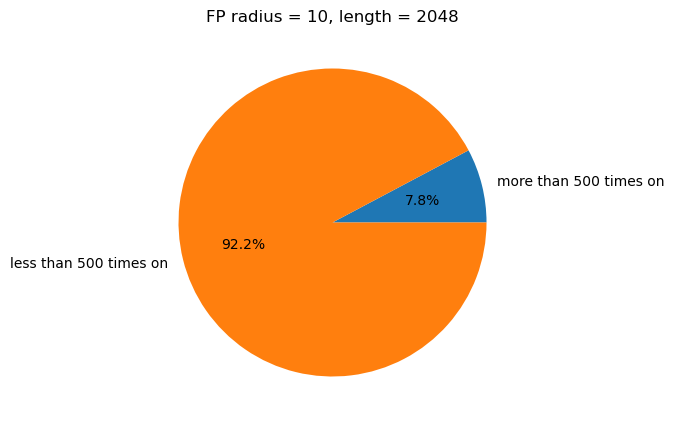

In [320]:
plt.figure(figsize=(5,5))
plt.pie([num_of_on_more_than_500_2048_10, num_of_on_less_than_500_2048_10], labels=['more than 500 times on', 'less than 500 times on'],autopct='%1.1f%%')
plt.title('FP radius = 10, length = 2048')

Text(0.5, 1.0, 'FP radius = 3, length = 2048')

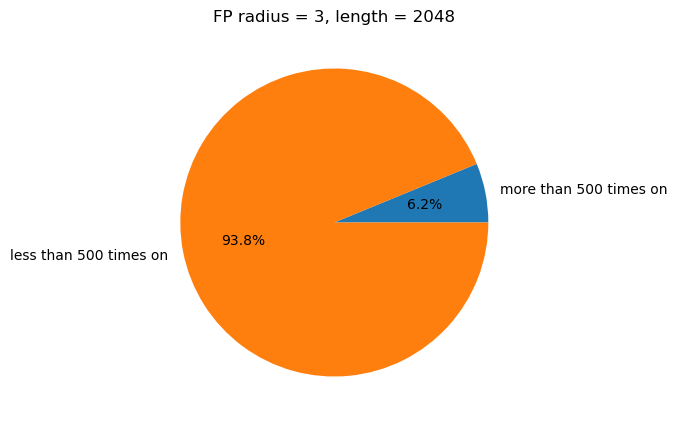

In [322]:
plt.figure(figsize=(5,5))
plt.pie([num_of_on_more_than_500_2048_3, num_of_on_less_than_500_2048_3], labels=['more than 500 times on', 'less than 500 times on'],autopct='%1.1f%%')
plt.title('FP radius = 3, length = 2048')

Text(0.5, 1.0, 'FP radius = 10, length = 8192')

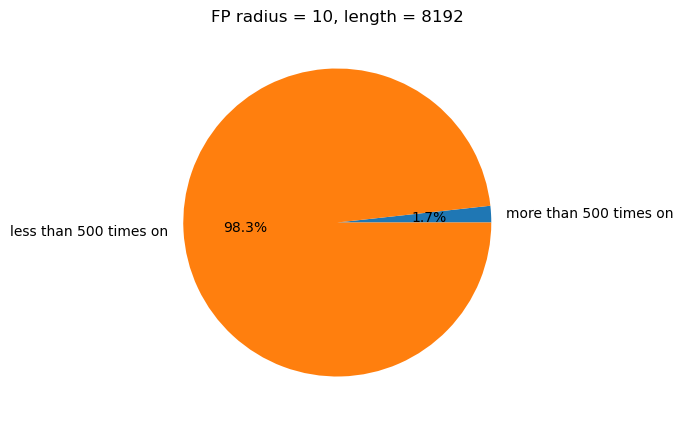

In [323]:
plt.figure(figsize=(5,5))
plt.pie([num_of_on_more_than_500_8192_10, num_of_on_less_than_500_8192_10], labels=['more than 500 times on', 'less than 500 times on'],autopct='%1.1f%%' )
plt.title('FP radius = 10, length = 8192')

As can be seen there is ceratinly a smaller portion of very frequently turned on bits for the longer fingerprint

### can definitely do some clustering this data too, but I will leave that for some other time

In [26]:
fps_steps_left_2049_10 = [np.append(fp,[steps_left]) for fp, steps_left in zip(fps_2048_10, dep_all_31_01.steps_left.values)]

In [129]:
fps_steps_left_2049_3 = [np.append(fp,[steps_left]) for fp, steps_left in zip(fps_2048_3, dep_all_31_01.steps_left.values)]

In [28]:
fps_steps_left_8193_10 = [np.append(fp,[steps_left]) for fp, steps_left in zip(fps_8192_10, dep_all_31_01.steps_left.values)]

In [30]:
X_2049_10 = torch.tensor(fps_steps_left_2049_10, dtype=torch.float32)

In [130]:
X_2049_3 = torch.tensor(fps_steps_left_2049_3, dtype=torch.float32)

In [42]:
X_8193_10 = torch.tensor(fps_steps_left_8193_10, dtype=torch.float32)

In [50]:
class MLP(nn.Module):
    def __init__(self,input_features=2049, dropout=0.):
        super(MLP, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=1024),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )
        self.out = nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        x = self.hidden(x)
        
        return self.out(x)
    
class MLP_wide(nn.Module):
    def __init__(self,input_features=8193, dropout=0.):
        super(MLP_wide, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=4096),
            nn.Dropout(p=dropout),
            nn.ReLU() ,
            nn.Linear(in_features=4096, out_features=1024),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )
        self.out = nn.Linear(in_features=64, out_features=1)
    
    def forward(self, x):
        x = self.hidden(x)
        
        return self.out(x)

In [51]:
class FPDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## We want to be able to predict the value of a molecule
### With the current data this is posssible because the agent's actions are deterministic
### However, because the data was produced during training of the agent, the policy is not constant
### Hence, the same molecule in the same step will lead to a different molecule being chosen
### Hence, it will be hard for our model to learn that a molecule in episode E, steps left S will have a value that is larger than the same molecule in episode E', steps left S' by an amount X
### Thus, trying to predict the value may be more confusing than trying to predict for example the discounted reward when we have the steps left appended to the fingerprint
### Hence, I will try to predict the discounted reward of a molecule and hope that this translates to the learning of the Q-network agent
However, below is some code that will give df_with_values which would have the values calculated
Note: I already tested learning them, and the results were generally bad

### As a first experiment I would like to look at the effects of the length of the fingerprint

### from the analysis up to now we are aware that with the large fingerprint there is around the same number of bits that are very frequently turned on, but the bits that are turned on rarely is much smaller for the shorter fingerprint (2048) than the longer fingerprint (8192)

In [45]:
# as my dataset I will get all the molecules from the first 250 episodes for training and the ones from the last 50 for testing
# that means that I am not checking for duplicates and there will definitely be such, especially in the last 50 episode
# there will later be another investigation into what happens if we remove them

In [48]:
train_X_2049_10, test_X_2049_10 = X_2049_10[:2500], X_2049_10[2500:]
train_X_2049_3, test_X_2049_3 = X_2049_3[:2500], X_2049_3[2500:]
train_X_8193_10, test_X_8193_10 = X_8193_10[:2500], X_8193_10[2500:]

In [47]:
y = dep_all_31_01['discounted_reward'].values
y = torch.tensor(y, dtype=torch.float32)
train_Y, test_Y = y[:2500], y[2500:]

In [49]:
fp_dataset_train_2049_10 = FPDataset(train_X_2049_10, train_Y)
fp_dataset_test_2049_10 = FPDataset(test_X_2049_10, test_Y)

train_loader_2049_10 = DataLoader(fp_dataset_train_2049_10, batch_size=128, shuffle=True)
test_loader_2049_10 = DataLoader(fp_dataset_test_2049_10, batch_size=128, shuffle=True)


fp_dataset_train_2049_3 = FPDataset(train_X_2049_3, train_Y)
fp_dataset_test_2049_3 = FPDataset(test_X_2049_3, test_Y)

train_loader_2049_3 = DataLoader(fp_dataset_train_2049_3, batch_size=128, shuffle=True)
test_loader_2049_3 = DataLoader(fp_dataset_test_2049_3, batch_size=128, shuffle=True)


fp_dataset_train_8193_10 = FPDataset(train_X_8193_10,train_Y)
fp_dataset_test_8193_10 = FPDataset(test_X_8193_10, test_Y)

train_loader_8193_10 = DataLoader(fp_dataset_train_8193_10, batch_size=128, shuffle=True)
test_loader_8193_10 = DataLoader(fp_dataset_test_8193_10, batch_size=128, shuffle=True)

In [59]:
mlp_2049_10 = MLP()
mlp_2049_3 = MLP()
mlp_8193_10 = MLP_wide()

In [60]:
optim_2049_10 = torch.optim.Adam(mlp_2049_10.parameters(), lr=0.00005)
optim_2049_3 = torch.optim.Adam(mlp_2049_3.parameters(), lr=0.00005)
optim_8193_10 = torch.optim.Adam(mlp_8193_10.parameters(), lr=0.00005)

In [57]:
def train(model, train_loader, optim, loss_fn):  
    model.train()
    epoch_loss = 0.
    for train_x, train_y in train_loader:
        y_hat = model(train_x)
        loss = loss_fn(y_hat, train_y.view(y_hat.shape))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader.dataset)

def test(model, test_loader, loss_fn):
    model.eval()
    epoch_loss = 0.
    with torch.no_grad():
        for test_x, test_y in test_loader:
            y_hat = model(test_x)
            loss = loss_fn(y_hat, test_y.view(y_hat.shape))
            epoch_loss += loss.item()
    return epoch_loss / len(test_loader.dataset)

In [61]:
train_losses_2049_10, train_losses_2049_3, train_losses_8193_10 = [], [], []
test_losses_2049_10, test_losses_2049_3, test_losses_8193_10 = [], [], []

In [62]:
criterion = nn.L1Loss()

In [63]:
for epoch in tqdm(range(100)):
    
    train_loss_2049_10 = train(mlp_2049_10, train_loader_2049_10, optim_2049_10, criterion)
    test_loss_2049_10 = test(mlp_2049_10, test_loader_2049_10, criterion)
    
    train_loss_2049_3 = train(mlp_2049_3, train_loader_2049_3, optim_2049_3, criterion)
    test_loss_2049_3 = test(mlp_2049_3, test_loader_2049_3, criterion)
    
    train_loss_8193_10 = train(mlp_8193_10, train_loader_8193_10, optim_8193_10, criterion)
    test_loss_8193_10 = test(mlp_8193_10, test_loader_8193_10, criterion)
    
    train_losses_2049_10.append(train_loss_2049_10)
    test_losses_2049_10.append(test_loss_2049_10)
    
    train_losses_2049_3.append(train_loss_2049_3)
    test_losses_2049_3.append(test_loss_2049_3)
    
    train_losses_8193_10.append(train_loss_8193_10)
    test_losses_8193_10.append(test_loss_8193_10)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [03:44<00:00,  2.24s/it]


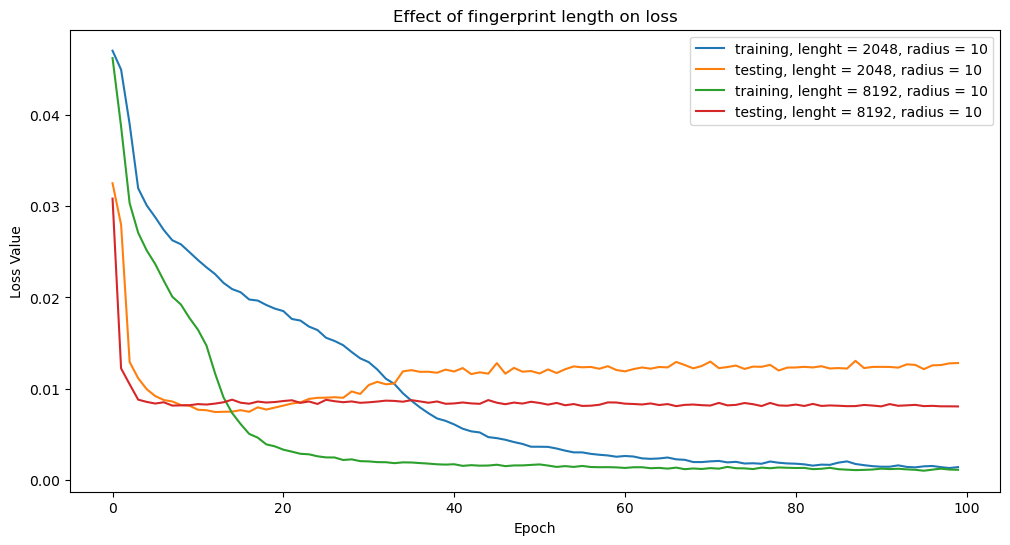

In [94]:
plt.figure(figsize=(12,6))
sn.lineplot(x=range(len(train_losses_2049_10)), y=train_losses_2049_10, label='training, lenght = 2048, radius = 10')
sn.lineplot(x=range(len(test_losses_2049_10)), y=test_losses_2049_10, label='testing, lenght = 2048, radius = 10')

sn.lineplot(x=range(len(train_losses_8193_10)), y=train_losses_8193_10, label='training, lenght = 8192, radius = 10')
sn.lineplot(x=range(len(test_losses_8193_10)), y=test_losses_8193_10, label='testing, lenght = 8192, radius = 10')

plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Effect of fingerprint length on loss')
plt.legend()

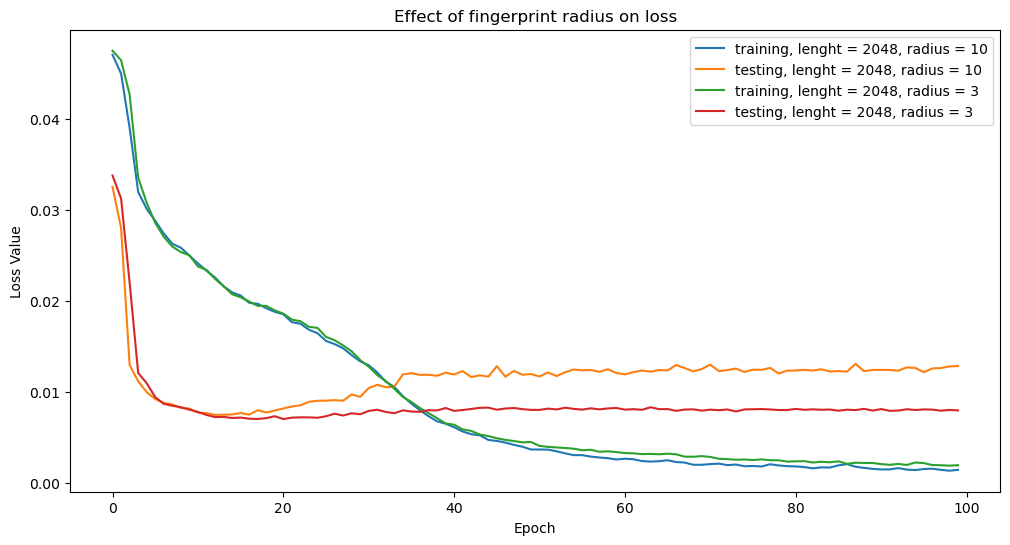

In [95]:
plt.figure(figsize=(12,6))
sn.lineplot(x=range(len(train_losses_2049_10)), y=train_losses_2049_10, label='training, lenght = 2048, radius = 10')
sn.lineplot(x=range(len(test_losses_2049_10)), y=test_losses_2049_10, label='testing, lenght = 2048, radius = 10')

sn.lineplot(x=range(len(train_losses_2049_3)), y=train_losses_2049_3, label='training, lenght = 2048, radius = 3')
sn.lineplot(x=range(len(test_losses_2049_3)), y=test_losses_2049_3, label='testing, lenght = 2048, radius = 3')

plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Effect of fingerprint radius on loss')
plt.legend()

## Conclusions

### However, I still don't want to split the data randomly because I care about whether the agent will learn the optimal policy in the final ~50 episodes

### Now take a step forward by looking at the effect of removing the duplicates

In [75]:
unique_instances_only = dep_all_31_01.drop_duplicates('discounted_reward')

In [76]:
unique_fps_2048_3 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=3, useChirality=True) for smi in unique_instances_only['smiles']]

In [77]:
unique_fps_2048_3 = [fp.ToList() for fp in unique_fps_2048_3]

In [79]:
unique_fps_steps_left_2049_3 = [np.append(fp,[steps_left]) for fp, steps_left in zip(unique_fps_2048_3, unique_instances_only.steps_left.values)]

In [80]:
X_unique_2049_3 = torch.tensor(unique_fps_steps_left_2049_3, dtype=torch.float32)

In [81]:
y = unique_instances_only['discounted_reward'].values
y = torch.tensor(y, dtype=torch.float32)

In [84]:
train_X_unique_2049_3, test_X_unique_2049_3, train_y_unique, test_y_unique = train_test_split(X_unique_2049_3, y, shuffle=False, test_size=0.2)

In [85]:
fp_dataset_train_unique_2049_3 = FPDataset(train_X_unique_2049_3, train_y_unique)
fp_dataset_test_unique_2049_3 = FPDataset(test_X_unique_2049_3, test_y_unique)

train_loader_unique_2049_3 = DataLoader(fp_dataset_train_unique_2049_3, batch_size=128, shuffle=True)
test_loader_unique_2049_3 = DataLoader(fp_dataset_test_unique_2049_3, batch_size=128, shuffle=True)

In [89]:
mlp_unique_2049_3 = MLP()
optim_unique_2049_3 = torch.optim.Adam(mlp_unique_2049_3.parameters(), lr=0.00005)

In [90]:
train_losses_unique_2049_3, test_losses_unique_2049_3 = [], []

In [91]:
for epoch in tqdm(range(100)):
    
    train_loss_unique_2049_3 = train(mlp_unique_2049_3, train_loader_unique_2049_3, optim_unique_2049_3, criterion)
    test_loss_unique_2049_3 = test(mlp_unique_2049_3, test_loader_unique_2049_3, criterion)
    
    train_losses_unique_2049_3.append(train_loss_unique_2049_3)
    test_losses_unique_2049_3.append(test_loss_unique_2049_3)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.70it/s]


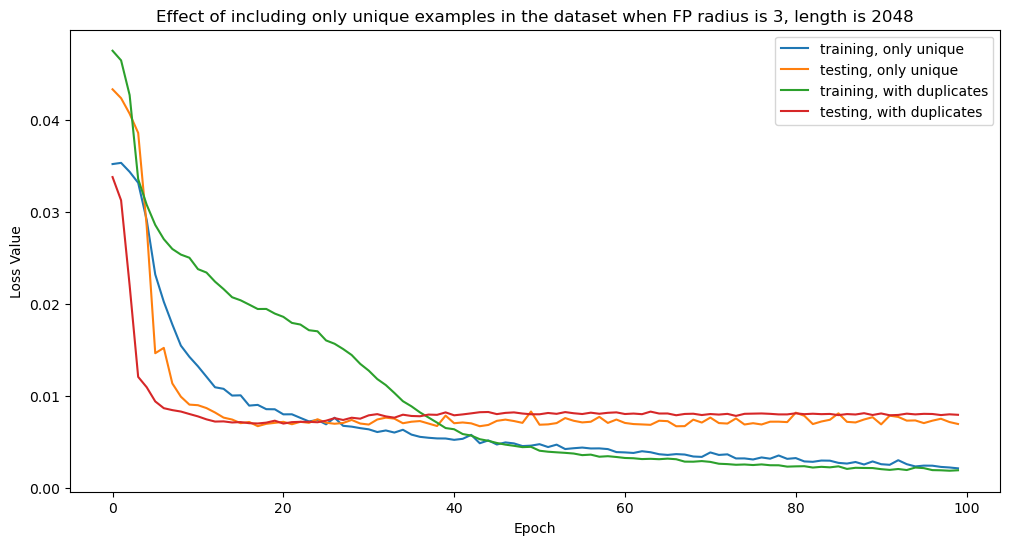

In [96]:
plt.figure(figsize=(12,6))
sn.lineplot(x=range(len(train_losses_unique_2049_3)), y=train_losses_unique_2049_3, label='training, only unique')
sn.lineplot(x=range(len(test_losses_unique_2049_3)), y=test_losses_unique_2049_3, label='testing, only unique')

sn.lineplot(x=range(len(train_losses_2049_3)), y=train_losses_2049_3, label='training, with duplicates')
sn.lineplot(x=range(len(test_losses_2049_3)), y=test_losses_2049_3, label='testing, with duplicates')

plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Effect of including only unique examples in the dataset when FP radius is 3, length is 2048')
plt.legend()

In [97]:
# effect of adding a metric that is correlated to the reward to the fingerprint

In [99]:
# using Pat Walter's silly score

In [100]:
ref_df = pd.read_csv("./chembl_drugs.smi", sep=" ", names=['SMILES', 'Name'])
class SillyWalks_fp_10:
    def __init__(self, df):
        self.count_dict = {}
        for smi in df.SMILES:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                fp = AllChem.GetMorganFingerprint(mol, 10, useChirality=True)
                for k, v in fp.GetNonzeroElements().items():
                    self.count_dict[k] = self.count_dict.get(k, 0) + v

    def score(self, smiles_in):
        mol = Chem.MolFromSmiles(smiles_in)
        if mol:
            fp = AllChem.GetMorganFingerprint(mol, 10, useChirality=True)
            on_bits = fp.GetNonzeroElements().keys()
            silly_bits = [
                x for x in [self.count_dict.get(x) for x in on_bits] if x is None
            ]
            score = len(silly_bits) / len(on_bits)
        else:
            score = 1
        return score
    

class SillyWalks_fp_3:
    def __init__(self, df):
        self.count_dict = {}
        for smi in df.SMILES:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                fp = AllChem.GetMorganFingerprint(mol, 3, useChirality=True)
                for k, v in fp.GetNonzeroElements().items():
                    self.count_dict[k] = self.count_dict.get(k, 0) + v

    def score(self, smiles_in):
        mol = Chem.MolFromSmiles(smiles_in)
        if mol:
            fp = AllChem.GetMorganFingerprint(mol, 3, useChirality=True)
            on_bits = fp.GetNonzeroElements().keys()
            silly_bits = [
                x for x in [self.count_dict.get(x) for x in on_bits] if x is None
            ]
            score = len(silly_bits) / len(on_bits)
        else:
            score = 1
        return score

In [101]:
silly_walker_10 = SillyWalks_fp_10(ref_df)
silly_walker_3 = SillyWalks_fp_3(ref_df)

In [102]:
dep_all_31_01['silly_10'] = dep_all_31_01['smiles'].apply(silly_walker_10.score)
dep_all_31_01['silly_3'] = dep_all_31_01['smiles'].apply(silly_walker_3.score)

Text(0.5, 0, 'Silly score, FP length 3')

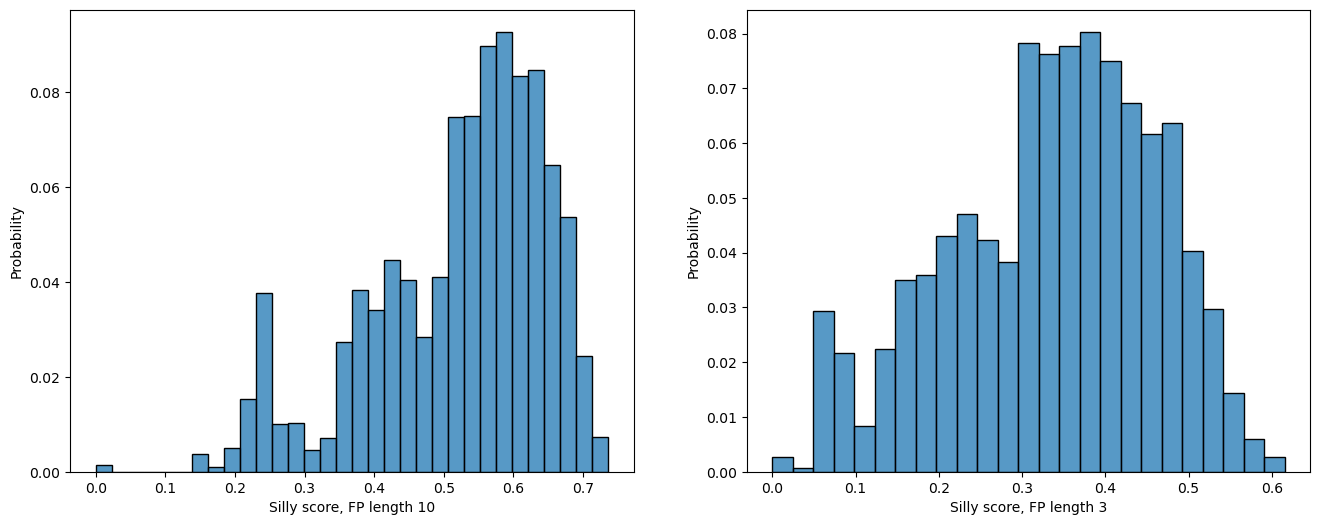

In [194]:
plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
sn.histplot(data=dep_all_31_01[~dep_all_31_01.index.duplicated()], x='silly_10', stat='probability', ax=ax1)
plt.xlabel('Silly score, FP length 10')

ax2 = plt.subplot(1,2,2)
sn.histplot(data=dep_all_31_01[~dep_all_31_01.index.duplicated()], x='silly_3', stat='probability', ax=ax2)
plt.xlabel('Silly score, FP length 3')

In [261]:
dep_all_31_01['episode_category'] = pd.cut(dep_all_31_01['episode'], labels=['0-50', '50-100', '100-150', '150-200', '200-250', '250-300'], bins=[-1,49, 99, 149, 199, 249, 300], )

Text(0, 0.5, 'Discounted Reward')

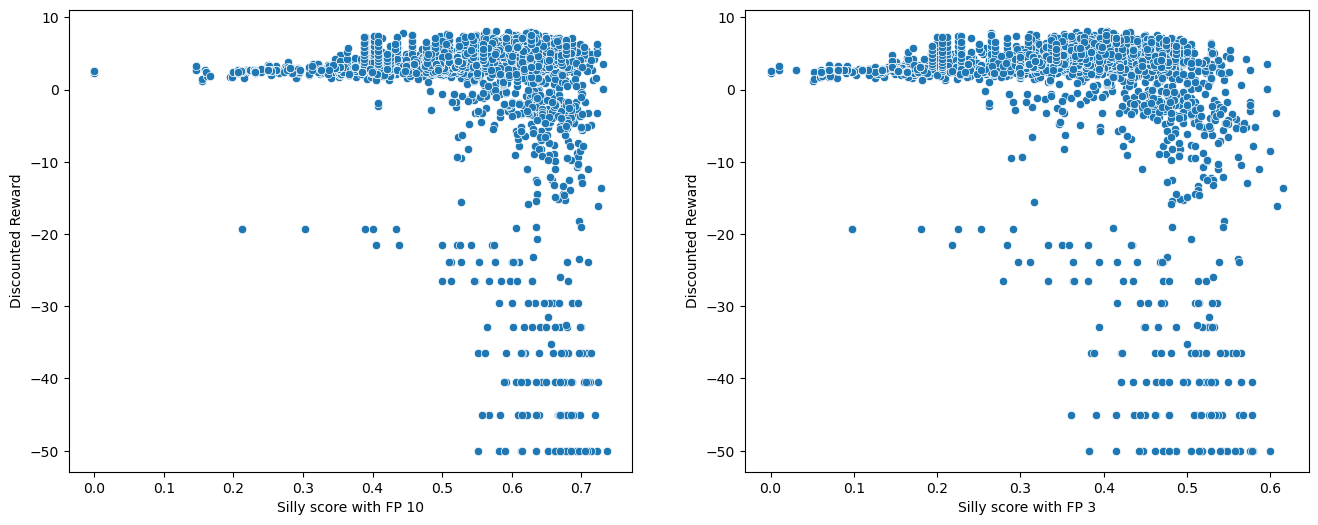

In [197]:
plt.figure(figsize=(16,6))
ax2 = plt.subplot(1,2,1)
sn.scatterplot(data=dep_all_31_01, x='silly_10', y='discounted_reward')
plt.xlabel('Silly score with FP 10')
plt.ylabel('Discounted Reward')

ax2 = plt.subplot(1,2,2)
sn.scatterplot(data=dep_all_31_01, x='silly_3', y='discounted_reward')
plt.xlabel('Silly score with FP 3')
plt.ylabel('Discounted Reward')

### there seems to be a good correlation between the silly score and the discounted reward

In [268]:
p_cor_3 = pearsonr(x=dep_all_31_01['silly_3'].values, y=dep_all_31_01['discounted_reward'])
p_cor_10 = pearsonr(x=dep_all_31_01['silly_10'].values, y=dep_all_31_01['discounted_reward'])

In [275]:
p_cor_3.statistic

-0.28667474507499163

In [274]:
p_cor_10.statistic

-0.20923473126312694

In [273]:
p_cor_3.pvalue

7.52152115917688e-58

In [272]:
p_cor_10.pvalue

4.97150365433546e-31

In [271]:
p_cor_3.confidence_interval()

ConfidenceInterval(low=-0.31918668113418064, high=-0.25348880891856707)

In [270]:
p_cor_10.confidence_interval()

ConfidenceInterval(low=-0.24320020154941616, high=-0.17475677172651694)

The correlation between the silly score and the discounted reward is stronger in the case of the FP=3, so I hope it will make a difference to the learning 

In [131]:
fps_silly_2050_10 = [np.append(fp, [silly_score_10]) for fp, silly_score_10 in zip(fps_steps_left_2049_10, dep_all_31_01['silly_10'])]
fps_silly_2050_3 = [np.append(fp, [silly_score_3]) for fp, silly_score_3 in zip(fps_steps_left_2049_3, dep_all_31_01['silly_3'])]

In [132]:
X_silly_10 = torch.tensor(fps_silly_2050_10, dtype=torch.float32)
X_silly_3 = torch.tensor(fps_silly_2050_3, dtype=torch.float32)

In [134]:
train_X_silly_10, test_X_silly_10 = X_silly_10[:2500], X_silly_10[2500:]
train_X_silly_3, test_X_silly_3 = X_silly_3[:2500], X_silly_3[2500:]

In [135]:
fp_dataset_train_silly_10 = FPDataset(train_X_silly_10, train_Y)
fp_dataset_test_silly_10 = FPDataset(test_X_silly_10, test_Y)

train_loader_silly_10 = DataLoader(fp_dataset_train_silly_10, batch_size=128, shuffle=True)
test_loader_silly_10 = DataLoader(fp_dataset_test_silly_10, batch_size=128, shuffle=True)

fp_dataset_train_silly_3 = FPDataset(train_X_silly_3, train_Y)
fp_dataset_test_silly_3 = FPDataset(test_X_silly_3, test_Y)

train_loader_silly_3 = DataLoader(fp_dataset_train_silly_3, batch_size=128, shuffle=True)
test_loader_silly_3 = DataLoader(fp_dataset_test_silly_3, batch_size=128, shuffle=True)

In [136]:
mlp_silly_3 = MLP(input_features=2050)
mlp_silly_10 = MLP(input_features=2050)

optim_silly_3 = torch.optim.Adam(mlp_silly_3.parameters(), lr=0.00005)
optim_silly_10 = torch.optim.Adam(mlp_silly_10.parameters(), lr=0.00005)

In [137]:
train_losses_silly_10, test_losses_silly_10 = [], []
train_losses_silly_3, test_losses_silly_3 = [], []

In [138]:
for epoch in tqdm(range(100)):
    
    train_loss_silly_10 = train(mlp_silly_10, train_loader_silly_10, optim_silly_10, criterion)
    test_loss_silly_10 = test(mlp_silly_10, test_loader_silly_10, criterion)
    
    train_losses_silly_10.append(train_loss_silly_10)
    test_losses_silly_10.append(test_loss_silly_10)
    
    train_loss_silly_3 = train(mlp_silly_3, train_loader_silly_3, optim_silly_3, criterion)
    test_loss_silly_3 = test(mlp_silly_3, test_loader_silly_3, criterion)
    
    train_losses_silly_3.append(train_loss_silly_3)
    test_losses_silly_3.append(test_loss_silly_3)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


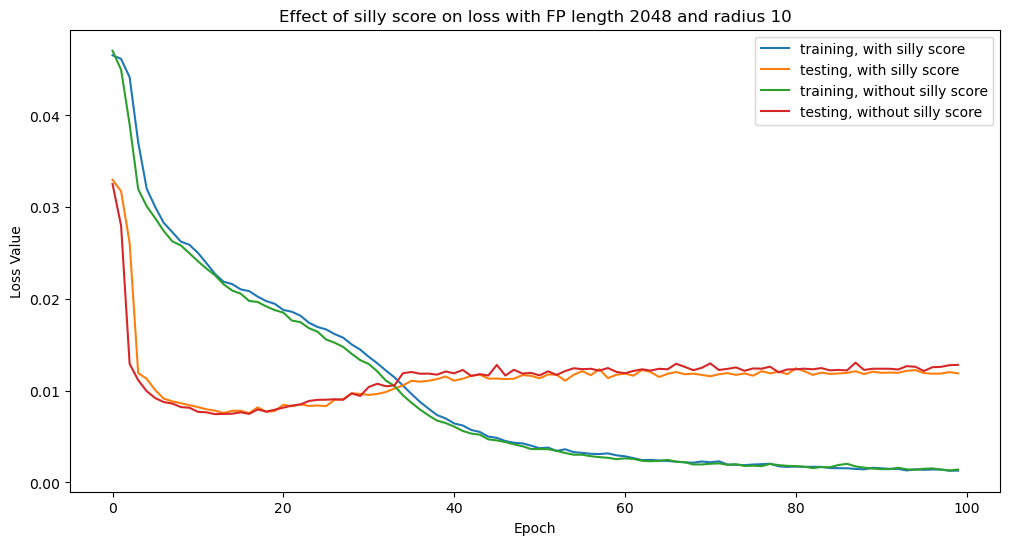

In [141]:
plt.figure(figsize=(12,6))
sn.lineplot(x=range(len(train_losses_silly_10)), y=train_losses_silly_10, label='training, with silly score')
sn.lineplot(x=range(len(test_losses_silly_10)), y=test_losses_silly_10, label='testing, with silly score')

sn.lineplot(x=range(len(train_losses_2049_10)), y=train_losses_2049_10, label='training, without silly score')
sn.lineplot(x=range(len(test_losses_2049_10)), y=test_losses_2049_10, label='testing, without silly score')

plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Effect of silly score on loss with FP length 2048 and radius 10')
plt.legend()

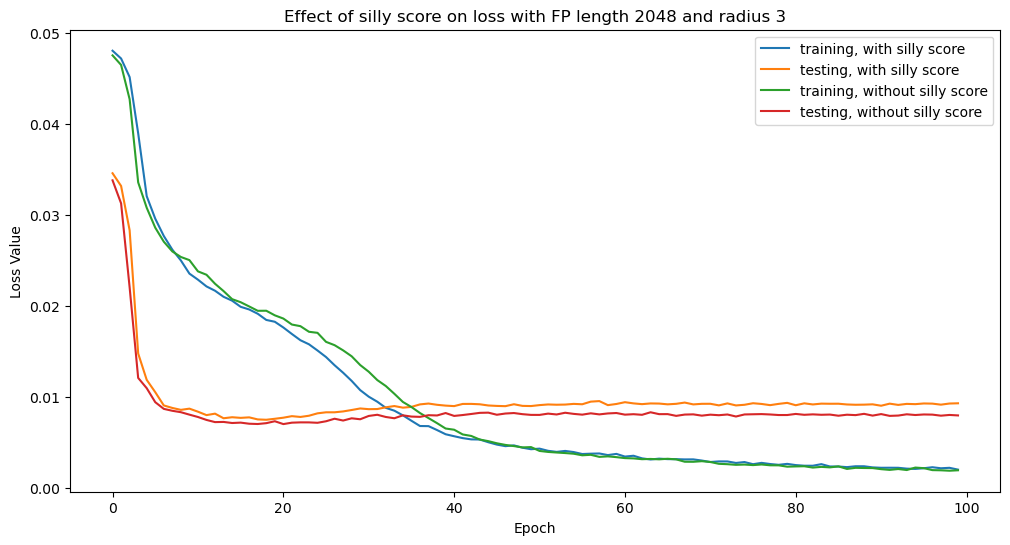

In [142]:
plt.figure(figsize=(12,6))
sn.lineplot(x=range(len(train_losses_silly_3)), y=train_losses_silly_3, label='training, with silly score')
sn.lineplot(x=range(len(test_losses_silly_3)), y=test_losses_silly_3, label='testing, with silly score')

sn.lineplot(x=range(len(train_losses_2049_3)), y=train_losses_2049_3, label='training, without silly score')
sn.lineplot(x=range(len(test_losses_2049_3)), y=test_losses_2049_3, label='testing, without silly score')

plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Effect of silly score on loss with FP length 2048 and radius 3')
plt.legend()

In [143]:
# pretty much appending the silly score didn't make a difference

In [180]:
y_hat_mlp_2049_3 = mlp_2049_3(train_X_2049_3)

Text(0, 0.5, 'y_true')

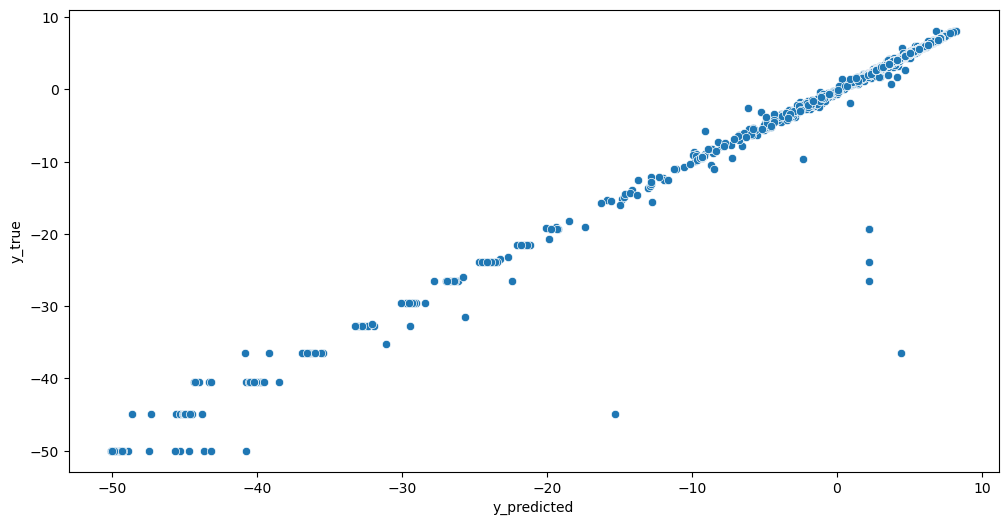

In [276]:
plt.figure(figsize=(12,6))
sn.scatterplot(x=y_hat_mlp_2049_3.detach().view(-1).numpy(), y=train_Y.numpy())
plt.xlabel('y_predicted')
plt.ylabel('y_true')

In [185]:
y_hat_mlp_test_2049_3 = mlp_2049_3(test_X_2049_3)

Text(0, 0.5, 'y_true')

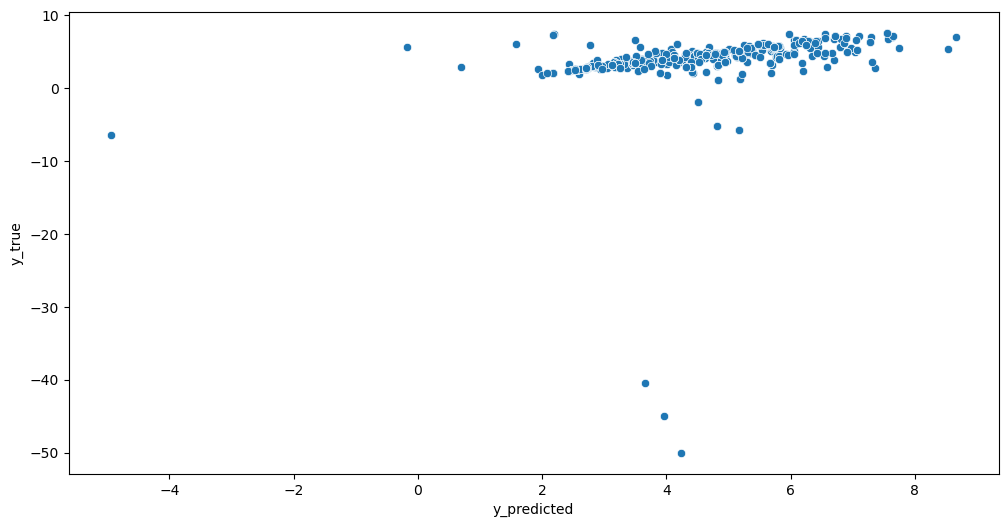

In [277]:
plt.figure(figsize=(12,6))
sn.scatterplot(x=y_hat_mlp_test_2049_3.detach().view(-1).numpy(), y=test_Y.numpy())
plt.xlabel('y_predicted')
plt.ylabel('y_true')

Pretty much as expected from the graphs, the model is overfitting